<h1 align="center"> FINITE DIFFERENCE SEISMIC MODELLING </h3>

<h3> STUDENT: MASAPANTA POZO, John </h3>

Sunday, 28th December, 2020\
Stavanger-Norway

In [399]:
import numpy as np
import matplotlib.pyplot as plt
import m8r as rsf
from IPython.display import clear_output
from scipy.signal import hilbert
import scipy.ndimage.filters
from IPython.display import clear_output

In [400]:
# Compute discrete laplacian of P
def laplace(M, dx):
    nz,nx = M.shape
    L = np.zeros(M.shape)
    for iz in range(1,nz-1):
        for ix in range(1,nx-1):        
            L[iz,ix] = M[iz,ix+1] + M[iz,ix-1] + M[iz+1,ix] + M[iz-1,ix] - 4*M[iz,ix] 
    L = L/(dx*dx)
    return L

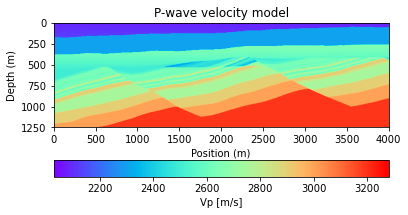

In [401]:
nz = 251
nx = 801
dz = 5 
dx = 5

fullsize = nz*nx
fin = open('vpfd.bin', 'rb')
vpdata = np.zeros([fullsize,1])
vpdata[0:fullsize,0] = st.unpack('f'*fullsize, fin.read(4*fullsize));
fin.close()
vpdata = vpdata.reshape([nz,nx])

plt.imshow(vpdata,aspect=1, extent=[0, (nx-1)*dx, (nz-1)*dz, 0], cmap='rainbow')
plt.xlabel('Position (m)')
plt.ylabel('Depth (m)')
plt.title('P-wave velocity model');
cbar = plt.colorbar(orientation='horizontal');

cbar.ax.set_xlabel('Vp [m/s]');

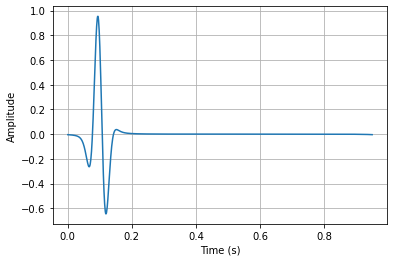

In [402]:
dt = 1e-3
dx = 5
nt=951

# Stability of FD 
dtstab = dx/(np.sqrt(2)*np.max(vpdata))
if(dt > dtstab):
    raise Exception('The value of dt should not exceed the stability limit of:', dtstab, 'The value of dt was:', dt)
        
t=np.linspace(0,nt-1,nt)*dt
f0=15 
t0=0.1
arg = np.pi*np.pi*f0*f0*(t-t0)**2
wav = (1-2*arg)*np.exp(-arg)

f = 2*np.pi*np.fft.fftfreq(51)/dt
wav = np.real(np.fft.ifft(np.fft.fft(hilbert(wav)*(np.exp(1j*np.pi/4)))))

plt.plot(t,wav)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()



In [403]:
# Model dimensions
nz,nx = vpdata.shape
dx = 5
dz = 5

# Variables for FD
laplacian = np.zeros([nz,nx])
P = np.zeros([nz,nx,3]) # Pressure at 3 consecutive times
Recording = np.zeros([nt,nx]) # Recording of pressure at a horizontal set of positions

# Source position in grid points
sx = 401
sz = 2

# Receiver depth for the recordings
rz = 2

dtvp2 = (dt**2)*((vpdata**2))
# Loop over time
for it in range(0,nt):
    # Compute laplace of P
    #laplacian = laplace(P[:,:,1],dx) # Very slow
    laplacian = scipy.ndimage.filters.laplace(P[:,:,1])/(dx*dx) # Much faster

    # Time stepping pressure
    P[:,:,2] = 2*P[:,:,1] - P[:,:,0] +  dtvp2 * laplacian

    # Adding source 
    P[sz,sx,2] = P[sz,sx,2] + (dt*dt)*wav[it]
    
    # Recording a seismogram 
    Recording[it, :] = P[rz,:,2]
    
    # Advancing pressure for next iteration
    P[:,:,0] = P[:,:,1] 
    P[:,:,1] = P[:,:,2]    
    
    if(it % 10 == 0):
        clear_output(wait=True)
        print('Progress:', np.round(100*it/(nt-1)), '%')
        
        
clear_output(wait=True)
print('Progress:', np.round(100*it/(nt-1)), '%')



Progress: 100.0 %


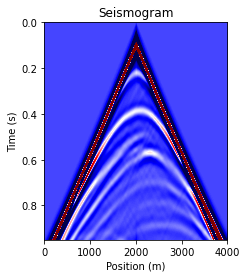

In [404]:
plt.imshow(Recording,vmin=0.05*np.min(Recording), vmax=0.05*np.max(Recording), 
           extent=[0, (nx-1)*dx, (nt-1)*dt, 0], aspect=5000, cmap='seismic');
plt.xlabel('Position (m)')
plt.ylabel('Time (s)')
plt.title('Seismogram');

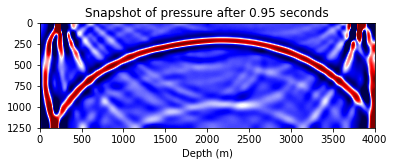

In [405]:
plt.imshow(P[:,:,2],vmin=0.05*np.min(Recording), vmax=0.05*np.max(Recording), 
           extent=[0, (nx-1)*dx, (nz-1)*dz, 0], cmap='seismic');
plt.xlabel('Position (m)')
plt.xlabel('Depth (m)')
plt.title('Snapshot of pressure after 0.95 seconds');


